In [3]:
import math
from operator import sub
import os
from pyotf.utils import prep_data_for_PR, remove_bg
from scipy.sparse import data

from scipy.spatial.distance import cdist
from tifffile import imread, imshow, imwrite
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

from functools import partial
from scipy.optimize import least_squares
from data.estimate_offset import estimate_offset
from data.visualise import scatter_3d, scatter_yz, show_psf_axial, plot_with_sphere
from debug_tools.est_calibration_stack_error import fit_plane
from util import get_base_data_path, split_for_training, dwt_dataset

from config.datafiles import res_file
from experiments.noise.noise_psf import generate_noisy_psf

from experiments.noise.low_pass_filter import apply_low_pass_img_stack

DEBUG = False



In [4]:
from config.datasets import dataset_configs
from data.datasets import TrainingDataSet

class SphereTrainingDataset(TrainingDataSet):
    filter_emitters_proximity = True
    
    disable_emitter_peak_boundary = True
    
    def __init__(self, config, z_range, filter_emitters_proximity=True, filter_low_intensity_emitters=True, split_data=False, lazy=False, transform_data=True, add_noise=False, normalize_psf=True, radius=5e5+50, exclude_coverslip=True):
        self.radius = radius
        self.exclude_coverslip = exclude_coverslip
        super().__init__(config, z_range, filter_emitters_proximity, filter_low_intensity_emitters, split_data, lazy, transform_data, add_noise, normalize_psf)

    def sphere_loss(self, p, fit_data=None):
        x0, y0, z0 = p
        x, y, z = fit_data.T
        return np.sqrt((x - x0) ** 2 + (y - y0) ** 2 + (z - z0) ** 2) - self.radius

    def fit_sphere(self, coords):
        initial_guess = [coords[:, 0].mean(), coords[:, 1].mean(), coords[:, 2].mean() + self.radius]

        low_bounds = [
            coords[:, 0].min(),
            coords[:, 1].min(),
            coords[:, 2].min(),
        ]
        high_bounds = [
            coords[:, 0].max(),
            coords[:, 1].max(),
            coords[:, 2].max() + (self.radius * 1.5),
        ] 
        sphere_loss = partial(self.sphere_loss, fit_data=coords)
        res = least_squares(sphere_loss, initial_guess, bounds=(low_bounds, high_bounds), verbose=True, ftol=1e-100,
                            xtol=1e-100, max_nfev=1000)
        centre = res.x[0:3]
        print(res.fun.min(), res.fun.max())
        print('Initial\t', initial_guess)
        print('Lower\t', low_bounds)
        print('Final\t', centre)
        print('Upper\t', high_bounds)
        
        return centre, res.fun
    
    def double_fit_sphere(self, _coords, subset=True, subset_idx=None):

        if subset_idx is None:
            coords = _coords
            subset_idx = np.arange(0, coords.shape[0])
        else:
            coords = _coords[subset_idx]
        centre, residuals = self.fit_sphere(coords)
        residuals = abs(residuals)
        # self.measure_error(coords, centre)
        if not subset:
            # cutoff = 500
            # points_idx = np.where(residuals < cutoff)[0]
            # subset_idx = subset_idx[points_idx]
            # print(f'Keeping {len(points_idx)} points from {_coords.shape[0]}.')
            # plot_with_sphere(_coords[subset_idx], centre, self.radius)
            return centre, subset_idx

        percentile = 95
        cutoff = np.percentile(residuals, percentile)
        points_idx = np.where(residuals < max(cutoff, 1))[0]

        print(f'Keeping {len(points_idx)} points from {_coords.shape[0]}.')

        subset_idx = subset_idx[points_idx]
        return self.double_fit_sphere(_coords, subset=False, subset_idx=subset_idx)
    

    def measure_error(self, coords, centre):
        corrected_coords = self.correct_z_pos(coords.copy(), centre)

        abs_error = abs(corrected_coords[:, 2] - coords[:, 2])
        if DEBUG:
            plt.boxplot(abs_error)
            plt.show()
        print(np.mean(abs_error))
        return np.mean(abs_error)

    def correct_z_pos(self, coords, sphere_centre):
        def get_z_coord(coord):
            a = 1
            b = 1 * (sphere_centre[2])
            c = sum([c ** 2 for c in sphere_centre]) \
                + (coord[0] ** 2) \
                + (coord[1] ** 2) \
                - (2 * ((coord[0] * sphere_centre[0]) + (coord[1] * sphere_centre[1]))) \
                - (self.radius ** 2)
            coeffs = [a, b, c]
            z_coords = np.roots(coeffs)
            z_coord = min(z_coords, key=lambda x: abs(x - coord[2]))

            return z_coord

        z_coords = np.copy(coords[:, 2])
        coords[:, 2] = np.apply_along_axis(get_z_coord, 1, coords)
        if DEBUG:
            plt.scatter(coords[:, 2], z_coords-coords[:, 2])
            plt.show()
        # Assert coordinates sit on sphere
        assert sum(self.sphere_loss(sphere_centre, coords)) < 1e-5
        return coords

    @staticmethod
    def trim_equal_length(psfs, z_pos):
        min_depth = min([len(zs) for zs in z_pos])
        z_pos = [zs[:min_depth] for zs in z_pos]
        psfs = [psf[:min_depth] for psf in psfs]
        return psfs, z_pos
    
    def remove_coverslip(self, psfs, xyz_coords):
        z_pos = xyz_coords[:, 2]
        lower_bound_z = z_pos.min() + self.config['coverslip_exclusion'][0]
        upper_bound_z = z_pos.max() - self.config['coverslip_exclusion'][1]
        keep_idx = np.where((lower_bound_z <= z_pos) & (z_pos <= upper_bound_z))[0]
        print(self.config['coverslip_exclusion'])
        print(f'Keeping {len(keep_idx)} points from {xyz_coords.shape[0]} after removing coverslip layers')
        psfs = np.array(psfs)[keep_idx]
        xyz_coords = xyz_coords[keep_idx]
        self.csv_data = self.csv_data.iloc[keep_idx]
        return psfs, xyz_coords
        
    def fetch_emitters_modelled_z(self):
        psfs, xyz_coords = self.estimate_ground_truth()
        psfs, xyz_coords = self.remove_coverslip(psfs, xyz_coords)
        return psfs, xyz_coords
        # from tifffile import imwrite
        # for i, psf in enumerate(psfs):
        #     imwrite(f'/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/tmp/psfs/{i}.tiff', psf, compress=6)
        # quit()

        psfs = np.stack(psfs)
        if DEBUG:
            scatter_yz(xyz_coords)
            scatter_3d(xyz_coords)
        print('\before')
        print(0, self.voxel_sizes[0]*self.img.shape[0])
        print(sorted(xyz_coords[:, 2]))
        sphere_centre, subset_idx = self.double_fit_sphere(xyz_coords, subset=True)
        print(f'{len(subset_idx)} emitters after fitting sphere')

        self.csv_data = self.csv_data.iloc[subset_idx]
        psfs = psfs[subset_idx]
        xyz_coords = xyz_coords[subset_idx]
        if DEBUG:
            # scatter_3d(xyz_coords)
            scatter_yz(xyz_coords)
        # plot_with_sphere(xyz_coords, sphere_centre, self.radius)

        # self.measure_error(xyz_coords, sphere_centre)
        xyz_coords = self.correct_z_pos(xyz_coords, sphere_centre)

        min_max_z = psfs[0].shape[0]/2
        z_placeholder = np.linspace(-min_max_z, min_max_z-1, psfs[0].shape[0]) * self.voxel_sizes[0]
        # trimmed_psfs = []
        # trimmed_zpos = []
        # for psf, offset in zip(psfs, xyz_coords[:, 2]):
        #     trim_psf, trim_zpos = self.trim_stack(psf, z_placeholder.copy() - offset) 
        #     if len(trim_zpos) != 40:
        #         continue
        #     trimmed_psfs.append(trim_psf)
        #     trimmed_zpos.append(trim_zpos)
        print('\nafter')
        print(0, self.voxel_sizes[0]*self.img.shape[0])
        print(sorted(xyz_coords[:, 2]))
        psfs, z_pos = zip(*[self.trim_stack(psf, z_placeholder.copy() + offset) for psf, offset in zip(psfs, xyz_coords[:, 2])])
        print(xyz_coords[:, 2])

        psfs, z_pos = self.trim_equal_length(psfs, z_pos)
        z_pos = np.stack(z_pos)
        
        xy_coords = xyz_coords[:, [0,1]]
        xy_coords = xy_coords[:, np.newaxis, :]
        z_pos = z_pos[:, :, np.newaxis]
        xy_coords_rep = np.repeat(xy_coords, z_pos.shape[1], axis=1)

        zxy_coords = np.concatenate((z_pos, xy_coords_rep), axis=2)
        return [psfs, zxy_coords]
    
    
    
    
if __name__=='__main__':

    z_range = 1000

    # dataset = 'paired_bead_stacks'
    # train_dataset = TrainingDataSet(dataset_configs[dataset]['training'], z_range, transform_data=False, add_noise=True)
    # exp_dataset = TrainingDataSet(dataset_configs[dataset]['experimental'], z_range, transform_data=False, add_noise=False, split_data=False)
    # print(np.stack(exp_dataset.all_psfs).shape)
    # print(exp_dataset.csv_data.shape)
    # dataset = 'other'
    # # train_dataset = TrainingDataSet(dataset_configs[dataset]['training'], z_range, transform_data=False, add_noise=False)
    # sphere_dataset = SphereTrainingDataset(dataset_configs[dataset]['sphere_ground_truth'], transform_data=False)

#     dataset = 'matched_index_sphere'
#     # train_dataset = TrainingDataSet(dataset_configs[dataset]['training'], z_range, transform_data=False, add_noise=True, filter_emitters_proximity=False, filter_low_intensity_emitters=False, split_data=True)
#     exp_dataset = SphereTrainingDataset(dataset_configs[dataset]['sphere_ground_truth_647nm'], transform_data=False, z_range=1000, split_data=True, add_noise=False, radius=5e5, lazy=True, filter_emitters_proximity=False, filter_low_intensity_emitters=False)

    dataset = 'olympus'
    # train_dataset = TrainingDataSet(dataset_configs[dataset]['training'], z_range, transform_data=False, add_noise=True, filter_emitters_proximity=False, filter_low_intensity_emitters=False, split_data=True)
    exp_dataset = SphereTrainingDataset(dataset_configs[dataset]['sphere_ground_truth'], transform_data=False, z_range=1000, split_data=True, add_noise=False, radius=5e5, lazy=True, filter_emitters_proximity=True, filter_low_intensity_emitters=False)

#     coords = gen_sphere_dataset(1e-8, radius=5e5)
#     exp_dataset.psf = coords
#     exp_dataset.double_fit_sphere(coords)

Reading img...
Loading /home/miguel/Projects/uni/data/smlm_3d/bead_3D_STORM_three_instruments/20210723_Olympus_beads/1mm_beads_agarose_centre_1/1mm_beads_agarose_centre_1_MMStack_Default.ome.tif
Loading /home/miguel/Projects/uni/data/smlm_3d/bead_3D_STORM_three_instruments/20210723_Olympus_beads/1mm_beads_agarose_centre_1/1mm_beads_agarose_centre_1_MMStack_Default_substack.csv


In [ ]:
psfs, coords = exp_dataset.fetch_emitters_modelled_z()
# coords = gen_sphere_dataset(1e-8, radius=5e5)
for psf in psfs:
    show_psf_axial(psf, '', 25)


In [25]:
import pandas as pd
df = pd.read_csv('/home/miguel/Projects/uni/phd/smlm_z/tmp.csv')

coords = df.to_numpy()
coords[:, 2] -= coords[:, 2].min()

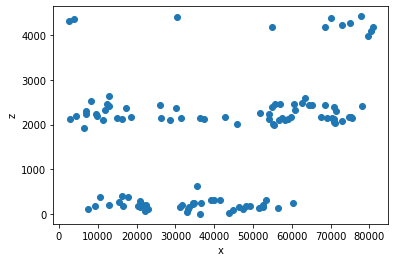

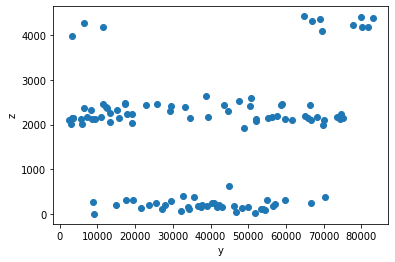

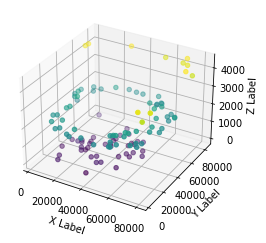

In [26]:
plt.scatter(coords[:, 0], coords[:, 2])
plt.xlabel('x')
plt.ylabel('z')
plt.show()

plt.scatter(coords[:, 1], coords[:, 2])
plt.xlabel('y')
plt.ylabel('z')
plt.show()
scatter_3d(coords)

`ftol` termination condition is satisfied.
Function evaluations 20, initial cost 4.5083e+14, final cost 4.5193e+13, first-order optimality 6.32e+10.
3.021266389953789 4497386.273770975
Initial	 [41584.13927839285, 39123.955924017864, 501712.4176575797, 500000.0]
Lower	 [2460.37666, 2346.82923, 0.0, 450000.0]
Final	 [ 34900.26057451  35352.22208454 450484.87204106]
Upper	 [80881.36622, 83031.10349, 1500000.0, 1500000.0]


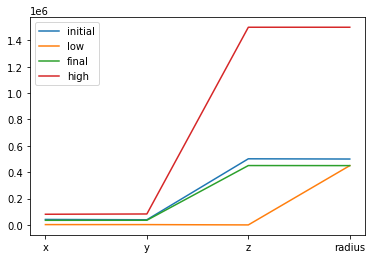

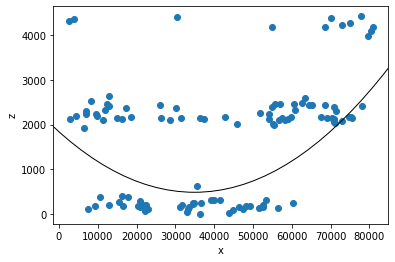

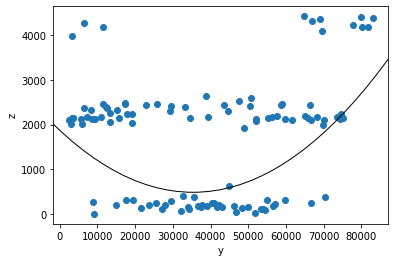

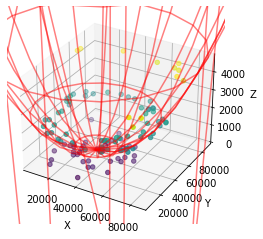

In [27]:
radius = 5e5

def sphere_loss(p, fit_data=None):
    x0, y0, z0, radius = p
    x, y, z = fit_data.T
    return (np.sqrt((x - x0) ** 2 + (y - y0) ** 2 + (z - z0) ** 2) - radius) ** 2

initial_guess = [coords[:, 0].mean(), coords[:, 1].mean(), coords[:, 2].mean() + radius, radius]

low_bounds = [
    coords[:, 0].min(),
    coords[:, 1].min(),
    coords[:, 2].min(),
    radius * 0.9,
]
high_bounds = [
    coords[:, 0].max(),
    coords[:, 1].max(),
    coords[:, 2].min() + (radius * 3),
    radius * 3,
] 
sphere_loss = partial(sphere_loss, fit_data=coords)
res = least_squares(sphere_loss, initial_guess, bounds=(low_bounds, high_bounds), verbose=True, ftol=1e-10,
                    xtol=1e-10, max_nfev=100)
centre = res.x[0:3]
radius = res.x[3]
print(res.fun.min(), res.fun.max())
print('Initial\t', initial_guess)
print('Lower\t', low_bounds)
print('Final\t', centre)
print('Upper\t', high_bounds)

plt.plot(initial_guess, label='initial')
plt.plot(low_bounds, label='low')
plt.plot(res.x, label='final')
plt.plot(high_bounds, label='high')
plt.xticks(list(range(len(res.x))), ['x', 'y', 'z', 'radius'])
plt.legend()
plt.show()

plt.figure()
ax = plt.gca()
plt.scatter(coords[:, 0], coords[:, 2])
circle = plt.Circle((centre[0], centre[2]), radius=radius, fill=False)
ax.add_artist(circle)
plt.xlabel('x')
plt.ylabel('z')
plt.show()

plt.figure()
ax = plt.gca()
plt.scatter(coords[:, 1], coords[:, 2])
circle = plt.Circle((centre[1], centre[2]), radius=radius, fill=False)
ax.add_artist(circle)
plt.xlabel('y')
plt.ylabel('z')
plt.show()


plot_with_sphere(coords, centre, radius)

In [1]:
from scipy.spatial.distance import cdist

def get_circle_z_coords(centre, radius, xy):
    x_diff = (xy[:, 0] - centre[0])**2
    y_diff = (xy[:, 1] - centre[1])**2
    sqrt = np.sqrt((radius**2)-(x_diff+y_diff))
    return centre[2] - sqrt

def plot_w_dist(centre, coords, radius):
    xy_dist = cdist([centre[0:2]], coords[:, [0,1]]).squeeze()
    z = coords[:, 2]

    plt.figure()
    ax = plt.gca()

    plt.scatter(xy_dist, z)
    circle = plt.Circle((0, centre[2]), radius=radius, fill=False)
    ax.add_artist(circle)

    plt.xlabel('x')
    plt.ylabel('z')
    plt.show()

plot_w_dist(centre, coords, radius)

corrected_z = get_circle_z_coords(centre, radius, coords)
_coords = coords.copy()
_coords[:, 2] = corrected_z

plot_w_dist(centre, _coords, radius)



NameError: name 'centre' is not defined

In [29]:
print(_coords.shape)
pixel_coords, filtered_df = exp_dataset.fetch_emitters_coords(exp_dataset.img, exp_dataset.csv_data)
print(np.stack(pixel_coords).shape)
psfs = []
z_range = exp_dataset.z_range*3
for pixel_coord, z_pos in zip(pixel_coords, coords[:, 2]):
    psf = exp_dataset.cut_image_stack(exp_dataset.img, pixel_coord, width=exp_dataset.bound)
    z_poses = np.arange(0, psf.shape[0] * exp_dataset.voxel_sizes[0], exp_dataset.voxel_sizes[0]).astype(float)
    z_poses -= z_pos
    valid_idx = np.where(abs(z_poses) <= z_range)[0]
    psf = psf[valid_idx]
    z_poses = z_poses[valid_idx]
    psf = psf / psf.max()
    print(psf.shape, (z_range*2)//exp_dataset.voxel_sizes[0])
    if len(psf)==(z_range*2)//exp_dataset.voxel_sizes[0]:
        psfs.append(psf)



(112, 3)
1377 emitters before filtering
206 emitters after proximity filtering.
197 emitters after borders
(197, 2)
(120, 32, 32) 120
(120, 32, 32) 120
(120, 32, 32) 120
(120, 32, 32) 120
(120, 32, 32) 120
(120, 32, 32) 120
(120, 32, 32) 120
(120, 32, 32) 120
(120, 32, 32) 120
(120, 32, 32) 120
(120, 32, 32) 120
(120, 32, 32) 120
(103, 32, 32) 120
(104, 32, 32) 120
(99, 32, 32) 120
(105, 32, 32) 120
(107, 32, 32) 120
(111, 32, 32) 120
(105, 32, 32) 120
(104, 32, 32) 120
(103, 32, 32) 120
(107, 32, 32) 120
(110, 32, 32) 120
(113, 32, 32) 120
(109, 32, 32) 120
(104, 32, 32) 120
(103, 32, 32) 120
(108, 32, 32) 120
(104, 32, 32) 120
(110, 32, 32) 120
(103, 32, 32) 120
(103, 32, 32) 120
(108, 32, 32) 120
(103, 32, 32) 120
(104, 32, 32) 120
(103, 32, 32) 120
(104, 32, 32) 120
(101, 32, 32) 120
(106, 32, 32) 120
(105, 32, 32) 120
(103, 32, 32) 120
(108, 32, 32) 120
(101, 32, 32) 120
(100, 32, 32) 120
(110, 32, 32) 120
(102, 32, 32) 120
(110, 32, 32) 120
(103, 32, 32) 120
(103, 32, 32) 120
(10

In [30]:
psf_concat = grid_psfs(psfs)

print(psf_concat.shape)
for i in range(0, psf_concat.shape[0], 10):
    plt.imshow(psf_concat[i] / psf_concat[i].max())
    plt.show()
from tifffile import imwrite

imwrite('/home/miguel/Projects/uni/phd/smlm_z/tmp.tif', psf_concat, compress=6)

NameError: name 'grid_psfs' is not defined

In [ ]:
import scipy.ndimage as ndi

for i in range(0, 100, 1):
    psf = exp_dataset.debug_emitter(i, z_range=10000, normalize=False)[0]
    peaks = np.max(psf, axis=(1,2))
    peaks = peaks / peaks.max()
    from scipy.interpolate import UnivariateSpline

    x = np.arange(0, peaks.shape[0])
    s = 0.1
    fit = UnivariateSpline(x, peaks, k=3, s=s)(x)
    
    diff = fit.max() / fit.mean()
    
    center_img = [d/2 for d in psf.shape[1:]]
    center_mass = ndi.center_of_mass(psf[np.argmax(fit)])
    offset = np.hypot(*[center_img[i] - center_mass[i] for i in range(2)])
    
    if diff < 1.5 or offset > 1.5:
        continue
    
    show_psf_axial(psf, '', 10)
    plt.imshow(psf[np.argmax(peaks)])
    plt.show()
    
    

    plt.scatter(x, peaks, label='real', marker='+')
    plt.plot(x, fit, label=f's={s}')
#     plt.xlim(50,150)
    plt.title(f'{np.argmax(fit)}')
    plt.legend()
    plt.show()
    print('--------------------------------------------------------------------------------')


In [ ]:
312 emitters before filtering
298 emitters after borders
100%|█████████████████████████████████████████████████████████████████████████████████| 298/298 [00:01<00:00, 225.83it/s]
59.1 49.2
20.6 13.9
149 emitters after fitting plane
Adding noise

In [ ]:
import math

import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.special import erf
from scipy.stats import norm
from csaps import csaps
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import scipy.ndimage as ndi


from config.optics import fwhm, voxel_sizes
from data.visualise import show_psf_axial, grid_psfs

est_sigma = (fwhm[0] / voxel_sizes[0]) * 1.5

DEBUG = False


def pdf(x):
    return 1 / math.sqrt(2 * math.pi) * math.exp(-x ** 2 / 2)


def cdf(x):
    return (1 + erf(x / math.sqrt(2))) / 2


def skew(x, s, e=0, w=1, a=0, c=0):
    t = (x - e) / w
    return (s * norm.pdf(t) * norm.cdf(a * t)) + c


def fit_gaussian(x, y):
    mean = np.argmax(y)
    peak = np.max(y)
    min_val = np.min(y)
    bounds = [
        (0, peak * 10),
        (0, len(y)),
        (0, len(y)),
        (-10, 10),
        (0, np.max(y))
    ]
    low_bounds, high_bounds = zip(*bounds)

    p0 = [peak, mean, np.mean(bounds[2]), 0, min_val]
    popt, _ = curve_fit(skew, x, y, p0=p0, bounds=(low_bounds, high_bounds),
                        maxfev=10000)
    return lambda x: skew(x, *popt)


def estimate_offset(psf, voxel_sizes=voxel_sizes, disable_boundary_check=False):
    target_psf_shape = psf.shape
    _psf = psf.copy()
    psf = psf.sum(axis=2)
    # if psf.dtype != 'uint16':
    #     psf /= psf.max()
    #     psf = psf.astype('uint16')
    #     psf *= 65535
    
    # psf = remove_bg(psf, multiplier=1.5)

    # psf = psf.astype(float) / psf.max()
    axial_max = psf.max(axis=(1))

    # axial_max = savgol_filter(axial_max, 11, 3)

    # # Normalise along axial_max
    min_val = axial_max.min()
    max_val = axial_max.max()
    axial_max = (axial_max - min_val) / (max_val - min_val)

    x = np.linspace(0, target_psf_shape[0]-1, num=target_psf_shape[0])

    s = 0.1
    sub_x = np.linspace(x.min(), x.max(), 100000, endpoint=True)

    cs = UnivariateSpline(x, axial_max, k=3, s=s)
    fit = cs(x)
    
    diff = fit.max() / fit.mean()
    
    center_img = [d/2 for d in psf.shape[1:]]
    center_mass = ndi.center_of_mass(psf[np.argmax(fit)])
    offset = np.hypot(*[center_img[i] - center_mass[i] for i in range(2)])

    if diff < 1.5 or offset > 1.5:
        raise RuntimeError

    peak = sub_x[np.argmax(cs(sub_x))]

    
    if not disable_boundary_check and not (len(x) * 0.3 < peak and peak < len(x) * 0.7):
        raise RuntimeError

    z_pos = (x.squeeze() -peak) * voxel_sizes[0]

    if DEBUG:
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(_psf[np.argmin(abs(z_pos))])
        axs[0].set_title(str(np.argmin(abs(z_pos))))
        axs[1].scatter(x, axial_max, label='data', marker='x')
        axs[1].plot(sub_x, cs(sub_x), linestyle='-', label='fit', color='orange')
        axs[1].set(xlabel='Frame in image stack (Z)', ylabel='Max pixel intensity')
        axs[1].legend()
        plt.show()
        
    # plt.plot(x, axial_max)
    # plt.plot(x, z_pos / z_pos.max())
    # plt.axvline(x=peak)
    # plt.show()
    return z_pos


    # fit_failed = False
    # gauss_func = fit_gaussian(x, axial_max)
    # # Reject points out of range
    # if np.argmax(axial_max) == 0:
    #     fit_failed = True

    # if fit_failed or mean_squared_error(axial_max, gauss_func(x)) > 5e-3:
    #     if DEBUG:
    #         plt.plot(x, axial_max, label='max')
    #         plt.plot(x, gauss_func(x), label='fit')
    #         plt.legend()
    #         plt.title(f'Failed: {float(mean_squared_error(axial_max, gauss_func(x)))}')
    #         plt.figure()
    #         show_psf_axial(_psf / _psf.max(), title=str(mean_squared_error(axial_max, gauss_func(x))))
    #     raise RuntimeError('Failed to fit gaussian to emitter')
    # else:
    #     # Cover range longer than stack in bead position not in measured range
    #     high_res_x = np.linspace(0, len(axial_max), 10000, endpoint=True)
    #     gauss_fit = gauss_func(high_res_x)
    #     peak = high_res_x[np.argmax(gauss_fit)]

    #     if DEBUG:
    #         plt.ylabel('Max pixel value in frame')
    #         plt.xlabel('Frame of image (i.e depth)')
    #         plt.plot(x, axial_max, label='max')
    #         plt.plot(high_res_x, gauss_func(high_res_x), label='fit')
    #         plt.legend()
    #         plt.title(f'{float(mean_squared_error(axial_max, gauss_func(x)))}')
    #         plt.show()
            # show_psf_axial((_psf / _psf.max()), title=str(peak))
    # if ground_truth:
    #     peak = ground_truth
    # peak=100
    z_pos = (x.squeeze() - peak) * voxel_sizes[0]
    return z_pos
